In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch

from core import (
    IMAGES_DIR,
    load_trained_models_for_inference,
    predict_pair,
)

In [7]:
from sklearn.metrics import roc_auc_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:

# For nicer plots
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = False

DATA_DIR = Path("data")
PAIRS_PATH = DATA_DIR / "pairs.csv"
RAW_POLY_DIR = DATA_DIR / "raw" / "polyvore_outfits"
ITEM_META_PATH = RAW_POLY_DIR / "polyvore_item_metadata.json"

print("IMAGES_DIR:", IMAGES_DIR)
print("PAIRS_PATH:", PAIRS_PATH)
print("ITEM_META_PATH:", ITEM_META_PATH)


IMAGES_DIR: C:\Users\eesha\Documents\VLR\Project\data\raw\polyvore_outfits\images
PAIRS_PATH: data\pairs.csv
ITEM_META_PATH: data\raw\polyvore_outfits\polyvore_item_metadata.json


In [4]:
def load_pairs(split: str = "test") -> pd.DataFrame:
    """Load test pairs from pairs.csv."""
    df = pd.read_csv(PAIRS_PATH)
    df = df[df["split"] == split].reset_index(drop=True)
    print(f"Loaded {len(df)} '{split}' pairs.")
    return df


def load_img_to_category() -> dict:
    """
    Build mapping: image_rel_path -> semantic_category (string),
    based on polyvore_item_metadata.json.
    """
    print(f"Loading item metadata from {ITEM_META_PATH}")
    with open(ITEM_META_PATH, "r") as f:
        meta = json.load(f)

    img_to_cat = {}
    for item_id, info in meta.items():
        img_path = info.get("image") or info.get("img") or ""
        if img_path.startswith("images/"):
            img_path = img_path[len("images/"):]
        if not img_path:
            img_path = f"{item_id}.jpg"

        cat = (
            info.get("semantic_category")
            or info.get("category")
            or info.get("categoryid")
            or "unknown"
        )
        img_to_cat[img_path] = str(cat).lower()

    print(f"Built img_to_cat mapping for {len(img_to_cat)} images.")
    return img_to_cat


def highlevel_cat(cat: str) -> str:
    """Coarse grouping of categories: top / bottom / shoe / other."""
    c = cat.lower()
    top_keywords = ["top", "blouse", "shirt", "tee", "t-shirt", "sweater", "hoodie", "jacket", "coat", "cardigan"]
    bottom_keywords = ["pant", "pants", "jean", "short", "skirt", "trouser", "legging"]
    shoe_keywords = ["shoe", "sandal", "boot", "heel", "sneaker", "loafer", "flat"]

    if any(k in c for k in top_keywords):
        return "top"
    if any(k in c for k in bottom_keywords):
        return "bottom"
    if any(k in c for k in shoe_keywords):
        return "shoe"
    return "other"


def compute_color_hist(img_path: Path, cache: dict, bins: int = 8) -> np.ndarray:
    """HSV color histogram + L2 norm, cached for speed."""
    key = str(img_path)
    if key in cache:
        return cache[key]

    img = Image.open(img_path).convert("RGB")
    img = img.resize((128, 128))

    hsv = img.convert("HSV")
    arr = np.array(hsv)

    h = arr[:, :, 0].flatten()
    s = arr[:, :, 1].flatten()
    v = arr[:, :, 2].flatten()

    hist_h, _ = np.histogram(h, bins=bins, range=(0, 256), density=False)
    hist_s, _ = np.histogram(s, bins=bins, range=(0, 256), density=False)
    hist_v, _ = np.histogram(v, bins=bins, range=(0, 256), density=False)

    hist = np.concatenate([hist_h, hist_s, hist_v]).astype(np.float32)
    norm = np.linalg.norm(hist) + 1e-8
    hist = hist / norm

    cache[key] = hist
    return hist


In [5]:
clip_model, preprocess, classifier = load_trained_models_for_inference()
clip_model.to(device)
classifier.to(device)

df_test = load_pairs(split="test")
img_to_cat = load_img_to_category()


c:\Users\eesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(
c:\Users\eesha\Documents\VLR\Project\core.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only

Loaded 4880 'test' pairs.
Loading item metadata from data\raw\polyvore_outfits\polyvore_item_metadata.json
Built img_to_cat mapping for 251008 images.


In [6]:
records = []
color_cache = {}

clip_model.eval()
classifier.eval()

for _, row in df_test.iterrows():
    img1_rel = row["img1"]
    img2_rel = row["img2"]
    y_true = int(row["label"])

    img1_path = IMAGES_DIR / img1_rel
    img2_path = IMAGES_DIR / img2_rel

    # load images
    img1 = Image.open(img1_path).convert("RGB")
    img2 = Image.open(img2_path).convert("RGB")

    # your helper returns (cos_sim, prob)
    cos_sim, prob = predict_pair(
        clip_model, preprocess, classifier, img1, img2
    )

    # color similarity
    h1 = compute_color_hist(img1_path, color_cache)
    h2 = compute_color_hist(img2_path, color_cache)
    color_sim = float(np.dot(h1, h2))

    # categories from metadata
    base1 = Path(img1_rel).name
    base2 = Path(img2_rel).name
    cat1_raw = img_to_cat.get(base1, "unknown")
    cat2_raw = img_to_cat.get(base2, "unknown")

    cat1_high = highlevel_cat(cat1_raw)
    cat2_high = highlevel_cat(cat2_raw)

    records.append(
        {
            "img1": img1_rel,
            "img2": img2_rel,
            "label": y_true,
            "prob_mlp": float(prob),
            "clip_cosine": float(cos_sim),
            "color_sim": color_sim,
            "cat1_raw": cat1_raw,
            "cat2_raw": cat2_raw,
            "cat1_high": cat1_high,
            "cat2_high": cat2_high,
        }
    )

df_scores = pd.DataFrame(records)
df_scores.head()


c:\Users\eesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


,img1,img2,label,prob_mlp,clip_cosine,color_sim,cat1_raw,cat2_raw,cat1_high,cat2_high
0,108702236.jpg,108786028.jpg,1,0.679046,0.750137,0.989826,bags,shoes,other,shoe
1,108702236.jpg,102975743.jpg,1,0.781283,0.803330,0.979458,bags,all-body,other,other
2,108786028.jpg,102975743.jpg,1,0.760481,0.771793,0.993207,shoes,all-body,shoe,other
3,100749834.jpg,106707342.jpg,1,0.713137,0.765814,0.741246,bags,shoes,other,shoe
4,100749834.jpg,110273121.jpg,1,0.737989,0.796358,0.640155,bags,all-body,other,other


In [9]:
auc_test = roc_auc_score(df_scores["label"].values, df_scores["prob_mlp"].values)
print(f"Sanity check MLP AUC on test: {auc_test:.3f}")


Sanity check MLP AUC on test: 0.762


In [10]:
TOP_K = 50  # you can change this

# False positives: label=0 but prob is HIGH (model thinks compatible)
fps = df_scores[df_scores["label"] == 0].copy()
fps = fps.sort_values("prob_mlp", ascending=False).head(TOP_K)
fps["error_type"] = "false_positive"

# False negatives: label=1 but prob is LOW (model thinks incompatible)
fns = df_scores[df_scores["label"] == 1].copy()
fns = fns.sort_values("prob_mlp", ascending=True).head(TOP_K)
fns["error_type"] = "false_negative"

failure_df = pd.concat([fps, fns], ignore_index=True)
print(f"Collected {len(fps)} FPs and {len(fns)} FNs (top {TOP_K}).")


Collected 50 FPs and 50 FNs (top 50).


In [11]:
failure_df.head()

,img1,img2,label,prob_mlp,clip_cosine,color_sim,cat1_raw,cat2_raw,cat1_high,cat2_high,error_type
0,110325303.jpg,101265503.jpg,0,0.821450,0.769842,0.871630,bags,outerwear,other,other,false_positive
1,113179700.jpg,103036431.jpg,0,0.820173,0.682514,0.910484,bags,sunglasses,other,other,false_positive
2,105240343.jpg,110956781.jpg,0,0.818505,0.760029,0.929949,bags,outerwear,other,other,false_positive
3,101727614.jpg,101283956.jpg,0,0.817528,0.672411,0.821192,accessories,bottoms,other,other,false_positive
4,114163275.jpg,106380720.jpg,0,0.817318,0.699733,0.982489,bags,sunglasses,other,other,false_positive


In [12]:
def show_pairs_grid(df_subset, title_prefix: str, max_pairs: int = 4):
    df_show = df_subset.head(max_pairs)
    n = len(df_show)
    plt.figure(figsize=(10, 3 * n))

    for row_idx, (_, row) in enumerate(df_show.iterrows()):
        img1 = Image.open(IMAGES_DIR / row["img1"]).convert("RGB")
        img2 = Image.open(IMAGES_DIR / row["img2"]).convert("RGB")

        # left image
        plt.subplot(n, 2, 2 * row_idx + 1)
        plt.imshow(img1)
        plt.axis("off")
        plt.title(
            f"{title_prefix} #{row_idx+1} – Item 1\n"
            f"{row['cat1_raw']} ({row['cat1_high']})"
        )

        # right image
        plt.subplot(n, 2, 2 * row_idx + 2)
        plt.imshow(img2)
        plt.axis("off")
        plt.title(
            f"Item 2\n{row['cat2_raw']} ({row['cat2_high']})\n"
            f"label={row['label']}, prob={row['prob_mlp']:.2f}, "
            f"clip={row['clip_cosine']:.2f}, color={row['color_sim']:.2f}"
        )

    plt.tight_layout()
    plt.show()


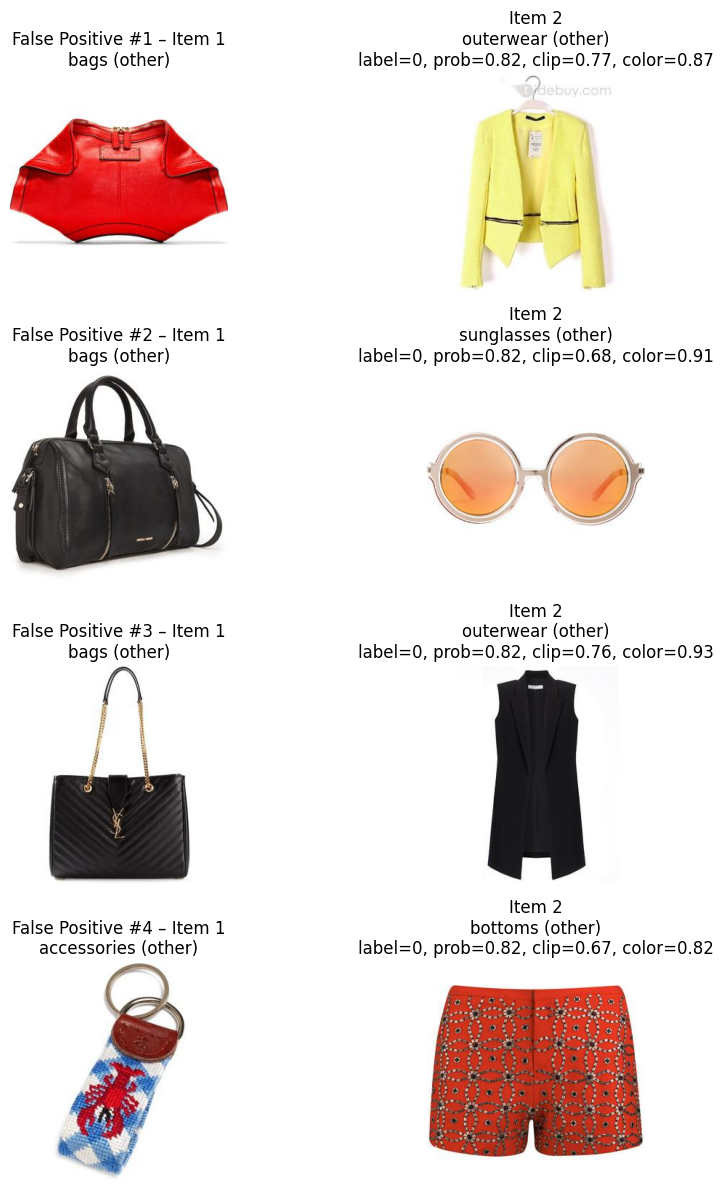

In [13]:
# Show 4 FPs
fp_examples = failure_df[failure_df["error_type"] == "false_positive"]
show_pairs_grid(fp_examples, title_prefix="False Positive", max_pairs=4)

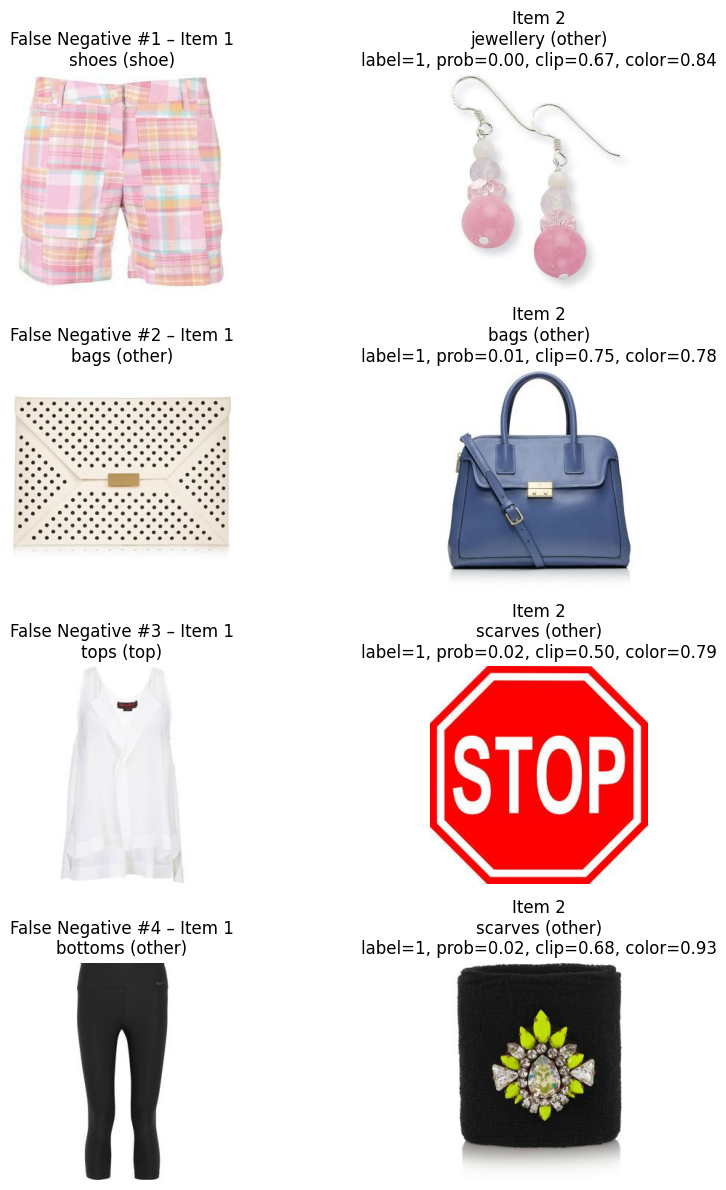

In [14]:
# Show 4 FNs
fn_examples = failure_df[failure_df["error_type"] == "false_negative"]
show_pairs_grid(fn_examples, title_prefix="False Negative", max_pairs=4)
